In [1]:
# allow access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import layers

In [3]:
strategy = tf.distribute.MirroredStrategy()

In [ ]:
# use for getting dataset on google drive
# df = pd.read_csv("drive/MyDrive")
# df = df.drop("Unnamed: 0", axis=1)

# load from csv
df = pd.read_csv("drive/MyDrive/labels.csv")
df = df.drop("Unnamed: 0", axis=1)

# temp full path. the purpose is to verify if all the image exist
df['full_path'] = "drive/MyDrive/dataset/license-plate/" + df['images']

# filter out rows where the image file doesn't exist
df = df[df['full_path'].apply(os.path.exists)]

# drop temp column
df = df.drop(columns=['full_path'])

# display updated DataFrame
df = df.reset_index(drop=True)
print(f"Updated DataFrame has {len(df)} rows.")
df.head(10)

Updated DataFrame has 17991 rows.


In [ ]:
df.images = "drive/MyDrive/dataset/license-plate/" + df.images

In [7]:
labels = df.labels.values.tolist()
images = df.images.values.tolist()

In [8]:
MAX_LENGTH = max([len(label) for label in labels])

labels = [label.ljust(MAX_LENGTH) for label in labels]

characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

In [9]:
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  17991
Number of labels found:  17991
Number of unique characters:  34
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [10]:
BATCH_SIZE = 128
IMG_WIDTH = 200
IMG_HEIGHT = 50

In [11]:
with strategy.scope():
    char_to_num = layers.StringLookup(
        vocabulary=characters, mask_token=None
    )

    num_to_char = layers.StringLookup(
        vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
    )

In [12]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)

    if shuffle:
        np.random.shuffle(indices)

    train_samples = int(size * train_size)

    X_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    X_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]

    return X_train, X_valid, y_train, y_valid

In [13]:
X_train, X_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [14]:
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.transpose(img, perm=[1, 0, 2])

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"image": img, "label": label}

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [16]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

In [ ]:
def build_model():

    # layer 1
    input_img = layers.Input(
        shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # layer 2
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)

    # layer 3
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # layer 4
    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)

    # layer 5
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # layer 6 
    new_shape = ((IMG_WIDTH // 4), (IMG_HEIGHT // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)

    # layer 7
    x = layers.Dense(64, activation="relu", name="dense1")(x)

    # layer 8
    x = layers.Dropout(0.2)(x)

    # layer 9
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)

    #layer 10
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # layer 11
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # layer 12
    output = CTCLayer(name="ctc_loss")(labels, x)

    # layer 13
    model = tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="v1"
    )

    opt = tf.keras.optimizers.Adam()

    model.compile(optimizer=opt)

    return model

In [18]:
with strategy.scope():
    model = build_model()

In [19]:
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

In [20]:
EPOCHS = 10
PATIENCE = 2

In [21]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=PATIENCE, restore_best_weights=True
)

In [22]:
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=[es],
)

Epoch 1/10
127/127 [==============================] - 334s 3s/step - loss: 22.8744 - val_loss: 20.2571
Epoch 2/10
127/127 [==============================] - 301s 2s/step - loss: 19.9908 - val_loss: 19.6948
Epoch 3/10
127/127 [==============================] - 301s 2s/step - loss: 19.6456 - val_loss: 19.5772
Epoch 4/10
127/127 [==============================] - 300s 2s/step - loss: 19.5398 - val_loss: 19.4800
Epoch 5/10
127/127 [==============================] - 301s 2s/step - loss: 19.4382 - val_loss: 19.3869
Epoch 6/10
127/127 [==============================] - 301s 2s/step - loss: 19.2616 - val_loss: 19.3068
Epoch 7/10
127/127 [==============================] - 301s 2s/step - loss: 18.8740 - val_loss: 18.4619
Epoch 8/10
127/127 [==============================] - 301s 2s/step - loss: 17.6401 - val_loss: 15.3037
Epoch 9/10
127/127 [==============================] - 302s 2s/step - loss: 12.0575 - val_loss: 8.4262
Epoch 10/10
127/127 [==============================] - 303s 2s/step - loss

In [23]:
prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

In [24]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :MAX_LENGTH
    ]

    output_text = []

    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)

    return output_text

4/4 [==============================] - 1s 137ms/step


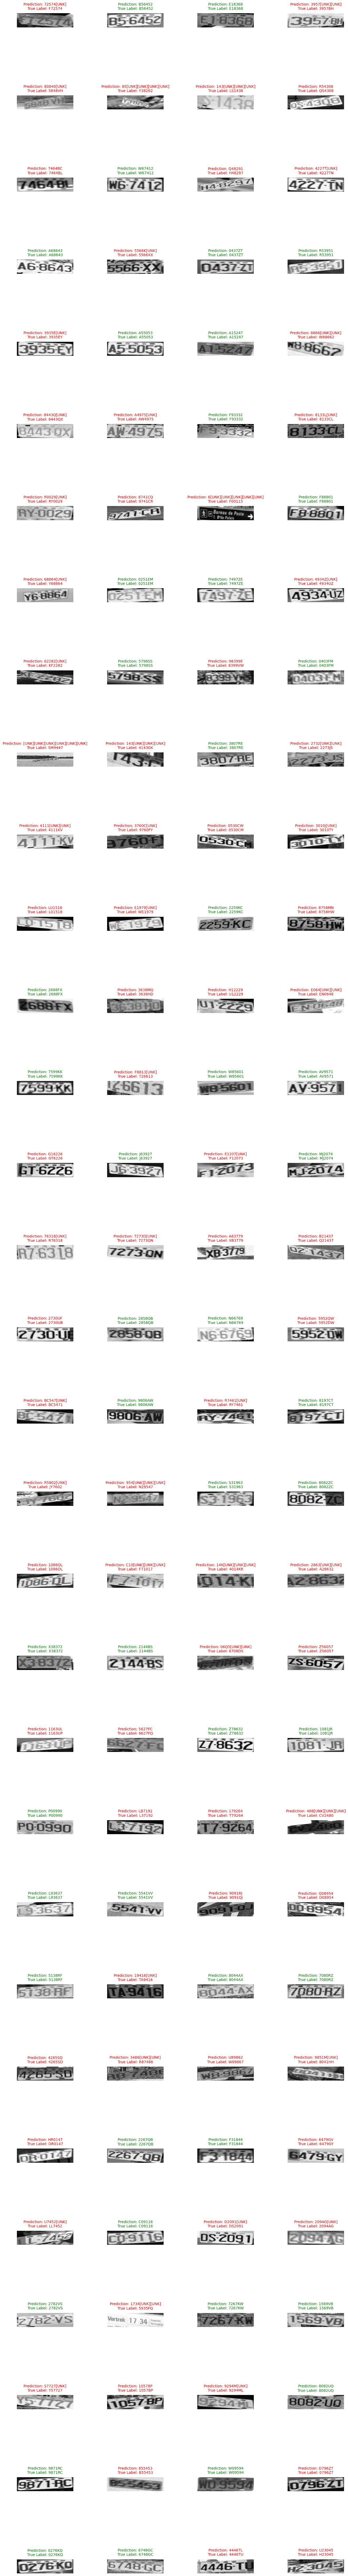

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# for each batch in validation dataset
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    # get label predictions
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    # get original labels
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    num_images = len(pred_texts)

    # dynamically calculate rows/columns based on the number of images
    num_cols = 4  # num of columns for building the table
    rows = np.ceil(num_images / num_cols).astype(int)  # Calculate the number of rows

    # create subplots dynamically
    _, ax = plt.subplots(rows, num_cols, figsize=(num_cols * 4, rows * 4))
    ax = ax.flatten()  # flatten the axes array for easier indexing

    for i in range(num_images):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T

        # green text color = prediction is correct
        # red text color = prediction is incorrect
        title_color = "green" if pred_texts[i] == orig_texts[i] else "red"

        # create the title for img
        title = f"Prediction: {pred_texts[i]}\nTrue Label: {orig_texts[i]}"

        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(title, fontsize=10, pad=10, color=title_color)
        ax[i].axis("off")

    for j in range(num_images, len(ax)):
        ax[j].axis("off")

    plt.subplots_adjust(hspace=0.6, wspace=0.6)
    plt.show()


4/4 [==============================] - 1s 162ms/step
True Labels Length: 2328
Predicted Labels Length: 2328


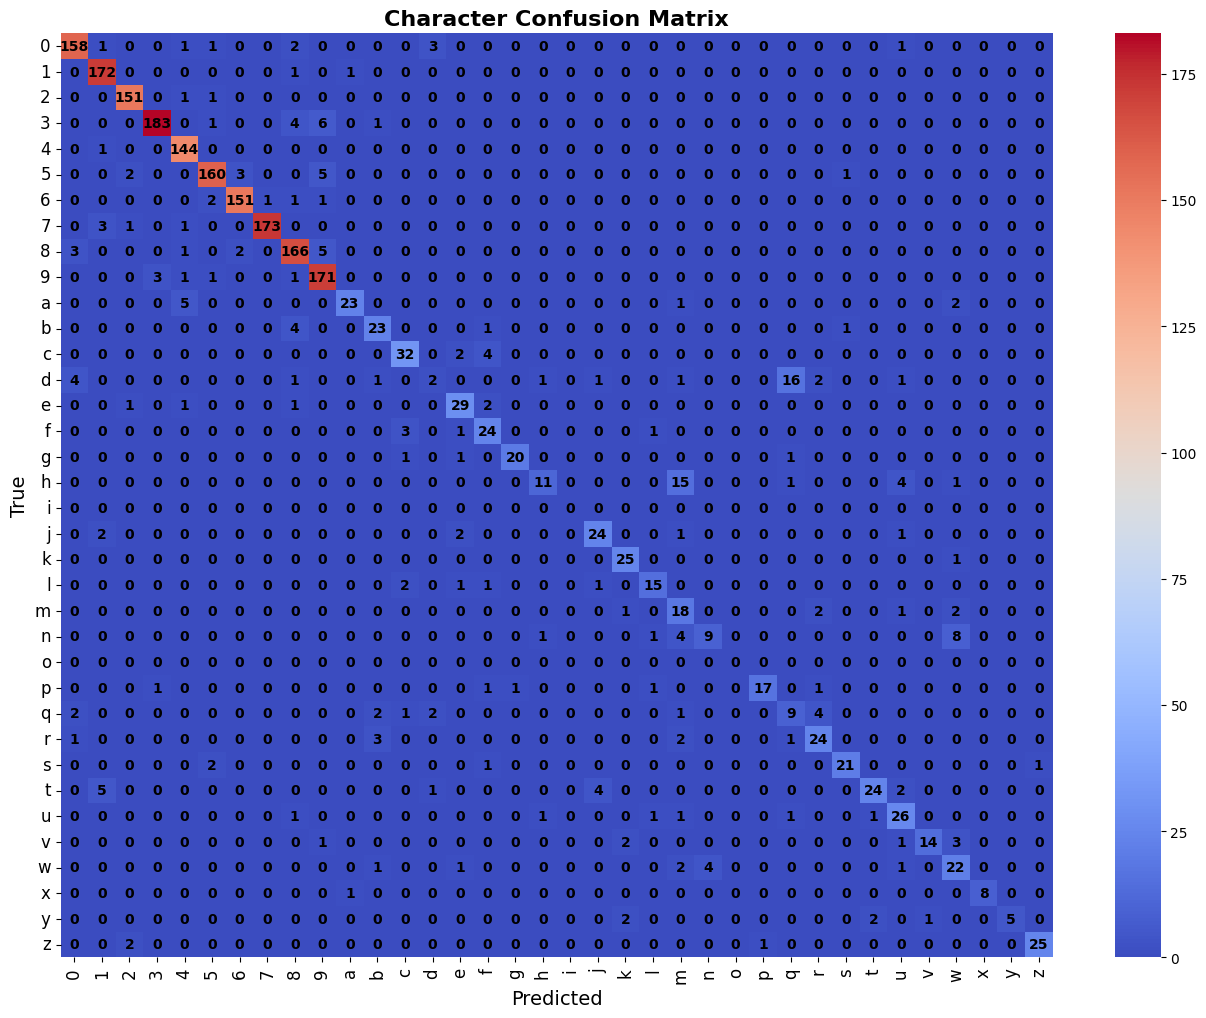

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = []
pred_labels = []

# collect all true labels and predicted labels from the validation dataset
for batch in validation_dataset.take(5):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    # get predictions
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    # get original labels and convert them to lowercase if necessary
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label.lower())

    # collect true labels and predicted labels, ensuring the length of both are the same
    for i in range(len(pred_texts)):
        # ensure only valid predictions are considered
        if len(orig_texts[i]) == len(pred_texts[i]):  # check if the lengths match
            true_labels.extend(list(orig_texts[i]))  # append each character of the true label
            pred_labels.extend(list(pred_texts[i].lower()))  # convert predictions to lowercase

print(f"True Labels Length: {len(true_labels)}")
print(f"Predicted Labels Length: {len(pred_labels)}")

# generate confusion matrix for the characters
cm = confusion_matrix(true_labels, pred_labels, labels=[str(i) for i in range(10)] + list("abcdefghijklmnopqrstuvwxyz"))

# plot confusion matrix using seaborn heatmap
plt.figure(figsize=(16, 12))  # Larger figure size for better clarity

sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=True,
            xticklabels=[str(i) for i in range(10)] + list("abcdefghijklmnopqrstuvwxyz"),
            yticklabels=[str(i) for i in range(10)] + list("abcdefghijklmnopqrstuvwxyz"),
            annot_kws={"size": 10, "weight": "bold", "color": "black"})

# rotate axis labels for better readability
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# add titles and labels
plt.title('Character Confusion Matrix', fontsize=16, weight='bold')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()
